# Pix2Pix-inspired Image Colorization using PyTorch

## 1  Introduction

Welcome to my first-ever in-depth ML project! In this notebook, I will be implementing a Pix2Pix-inspired image colorization model using PyTorch. The goal is to colorize 256x256 grayscale images by training a Generative Adversarial Network (GAN). In my opinion it is one of the most interesting applications of generative deep learning, as not so long ago it was considered impossible to achieve good results in this field without human intervention. I believe that many people may find this project useful, as it is a great introduction to CNNs, GANs, and image processing in general. The code is well-documented and the training process is not very hardware demanding, so it should be relatively quick to train (a few hours) on a modern GPU (depending on the size of your dataset and desired accuracy). I hope you will enjoy this project as much as I did!

By the end of this notebook, the model will be able to colorize images like this:

### 1.1  A peek at the results

![title](resources/results.png)

## 2  Approach

When loading image files they will usually be in an RGB format (3-channels, one for each: Red, Green, Blue). In such case, the model would have to predict 1 of 255^3 = ~16,5 million values for each pixel in the image. To make it easier for the model to learn, it is a common approach to convert the image to L\*a\*b\* color space first. This format consists of 3 channels: L (lightness), a (green to red), and b (blue to yellow). The L channel is the grayscale version of the image represented as pixel values in [0, 100] range, while the a and b channels contain the color information. Both are represented as arrays of values in [-128, 127] range on Green-Red and Blue-Yellow axes. Now, the model has to choose only 1 of 255^2 = ~65,000 values since the L channel is the grayscale input scaled to [0,100]. This conversion is crucial to achieving state-of-the-art results. It will not only simplify the training process for the model in terms of color choice but also preserve the original shapes of the input image, so the model won't have to reconstruct them from scratch.


![title](resources/lab.png)

Below is an example of respectively: L, a, b channels and then the full Lab/RGB image:

![title](resources/gray.png)
![title](resources/a.png)
![title](resources/b.png)
![title](resources/full.png)

## 3  Training Strategy

### 3.1 Model architecture

To achieve the goal I will use a Pix2Pix architecture, first presented in 2016 in the <a href='https://arxiv.org/abs/1611.07004'>Image-to-Image Translation with Conditional Adversarial Networks paper</a>, which I was inspired by when building this project. I've implemented the base solution from the paper and then refined it by doing research. Things that differ from the original paper are: Instance Normalization instead of Batch Normalization, Least-Squares GAN Loss instead of regular Binary Cross-entropy GAN Loss. Both I found being advised by the authors of the paper on <a href='https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix'>GitHub</a>.

![title](resources/pix2pix.png)

### 3.2 Data and objective function

The generator will be trained on 256x256 images from a subset of the <a href='https://www.image-net.org'>ImageNet1K</a> dataset. You can download it on <a href='https://www.kaggle.com/datasets/dimensi0n/imagenet-256'>Kaggle</a>. I've also extended it with a <a href='https://www.kaggle.com/datasets/badasstechie/celebahq-resized-256x256'>CelebA</a> and <a href='https://www.kaggle.com/datasets/gpiosenka/sports-classification'>Sports</a> datasets for the model to colorize people better.
Losses for the generator are going to be L1 Loss, which will measure the 'distance' between the predicted and target color values, as well as make it a regression task. The second one is the LSGAN loss mentioned before (MSE Loss essentially), which is the adversarial loss used for both generator and discriminator.

One important thing about using ImageNet for colorization training is to clean the data. In context of our task it means to delete all of the grayscale images, as they are considered outliers, which may corrupt the learning process. I found over 7,000 of such images, which is a bit more than 1% of the dataset. That's not a negligible amount. You can use a function to do this automatically:

In [2]:
directory = Path('images/train')

for file in directory.iterdir():
    if file.is_file():
        gray = False
        with Image.open(file) as img:
            if img.mode == 'L':  # Check if the image is grayscale
                print(f"Deleting {file.name}")
                gray = True
        if gray:
            os.remove(file)

## 4  GAN Overview

Generative Adversarial Network is a type of deep learning architecture created by Ian Goodfellow in 2014 in <a href='https://arxiv.org/abs/1406.2661'>a paper</a> of the same name. The main concept is that the generative model called the generator not only tries to minimize the loss based on the outputs and targets but also compete with another model called the discriminator, which tries to distinguish between real and generated (fake) images. While the generator tries to 'fool' the discriminator by producing more and more convincing outputs, the discriminator is improving at the same time. Such approach turned out to be very effective and commonly used nowadays for generative purposes.

### 4.1 Training process

#### 4.1.1  Discriminator training phase
<li>The discriminator receives a batch of real images from the dataset, labeled as real, and learns to classify them correctly as real.</li>
<li>The generator produces a batch of fake images from its input.</li>
<li>The discriminator receives the fake images produced by the generator, labeled as fake, and learns to classify them correctly as fake.</li>
<li>The discriminator's objective is to maximize the accuracy in distinguishing real images from fake images by minimizing the classification error for both.</li>   

#### 4.1.2  Generator training phase
<li>Instead of labeling the fake images as fake, the fake images are labeled as real for the generator’s training. The goal is to train the generator to "fool" the discriminator into classifying the fake images as real.</li>
<li>The generator is trained by updating its parameters based on the feedback from the discriminator, minimizing the loss that indicates how easily the discriminator can detect fake images.</li>
<li>The generator's objective is to improve until the discriminator is unable to distinguish between real and fake images with high confidence.</li>

### 4.2 Loss functions

#### 4.2.1  L1 Loss
It is a regression loss that measures the mean absolute error between the predicted and target values. It is used to measure the difference between the predicted and target color values. Here is the formula for the L1 Loss:



![title](resources/l1.png)

where x is the input, y is the target, z is random noise and G(x,z) is the output of the generator.

Actually, in Pix2Pix the noise isn't passed to the generator explicitly, but it is present in the models' architecture. That is because Dropout and InstanceNorm layers stay active during inference, which will assure the stochastic nature of GANs and produce slightly different output each time.

#### 4.2.2  Least Squares GAN Loss
It is a loss function that measures the mean squared error between the predicted and target values, where target values are real or fake labels assigned to the input of the discriminator. It is used as the adversarial loss for both the generator and the discriminator. Such approach for training GANs was first described in <a href='https://arxiv.org/abs/1611.04076'>Least Squares Generative Adversarial Networks</a> paper. Here is the formula for the Least Squares GAN Loss:

![title](resources/lsgan.png)

where a is the fake label and b is the real label.

When calculating the loss for the generator both L1 and LSGAN losses are summed, the first one being multiplied by a lambda coefficient. In the original paper this value was 100 but when applying LSGAN value around 10-25 works better, as MSE produces smaller values than BCE, so the original ratio will be more or less preserved.

## 5  Implementation

### 5.1 Required imports

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm.notebook import tqdm
import kornia.color as color
from datetime import datetime
from pathlib import Path
import os

c:\Users\matik\anaconda3\Lib\site-packages\kornia\feature\lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


### 5.2 Constants
Here I define the constants that will be used throughout the notebook. This makes adjusting hyperparameters more convenient.


In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = Path('images')
TRAIN_DIR = DATA_DIR / 'train'
VAL_DIR = DATA_DIR / 'val'
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
IMAGE_SIZE = 256
LOAD_MODEL = False
SAVE_MODEL = True
MODEL_SOURCE = ...

Batch size of 4 was the choice of the Pix2Pix authors for image colorization task. Fewer examples in a batch result in more noise, which provides more diversity and less chance of overfitting. However, the main goal of such low batch size was getting a Batch Normalization to work similarly to an Instance Normalization. Since in this project the Instance Normalization is implemented directly, the batch size should not have a significant impact on the results. You can try different values but I found 16 to be the sweet-spot between high variance and parallel training efficiency. The learning rate of 2e-4 is the original paper's value. Default size is 256x256 but the model should work on any, as long as its a power of 2, bigger than 256x256 (if you train it on such data).

### 5.3 Utility functions
Here I define the utility functions that will be used throughout the notebook. Look at the comments in the code to understand what each function does.

In [5]:
def normalize_lab(L, ab):
    """
    Normalize the L and ab channels of an image in Lab color space.
    (Even though ab channels are in [-128, 127] range, divide them by 110 because higher values are very rare. 
    This makes the distribution closer to [-1, 1] in most cases.)
    """
    L = L / 50. - 1.
    ab = ab / 110.
    return L, ab

def denormalize_lab(L, ab):
    """
    Denormalize the L and ab channels of an image in Lab color space.
    (reverse of normalize_lab function)
    """
    L = (L + 1) * 50.
    ab = ab * 110.
    return L, ab

# Class below is taken from a notebook of a similar project
# https://colab.research.google.com/github/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/Image%20Colorization%20with%20U-Net%20and%20GAN%20Tutorial.ipynb
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count
        
# Function below is taken from a notebook of a similar project
# https://colab.research.google.com/github/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/Image%20Colorization%20with%20U-Net%20and%20GAN%20Tutorial.ipynb
def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {
        'loss_D_fake': loss_D_fake,
        'loss_D_real': loss_D_real,
        'loss_D': loss_D,
        'loss_G_GAN': loss_G_GAN,
        'loss_G_L1': loss_G_L1,
        'loss_G': loss_G,
    }

def visualize(generator, data, epoch, split, directory, num):
    """
    Visualize the results of the generator on specified data.
    Used for training and inference validation.
    """
    
    # Generate output
    generator.eval()
    with torch.no_grad():
        L, ab = data
        L, ab = L.to(DEVICE), ab.to(DEVICE)
        fake_ab = generator(L)
    generator.train()
    
    fake_ab = fake_ab.detach()
    
    # Denormalize and convert to RGB
    L, ab = denormalize_lab(L, ab)
    _, fake_ab = denormalize_lab(0, fake_ab)
    real_imgs = color.lab_to_rgb(torch.cat([L, ab], dim=1)).permute(0, 2, 3, 1).cpu()
    fake_imgs = color.lab_to_rgb(torch.cat([L, fake_ab], dim=1)).permute(0, 2, 3, 1).cpu()
    L = L.permute(0, 2, 3, 1).cpu()

    # Plot the results
    fig = plt.figure(figsize=(15, 8))
    for i in range(num):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i], cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")

    # Save the plot
    path = Path(f"outputs/{directory}/{split}")
    path.mkdir(exist_ok=True, parents=True)
    
    fig.savefig(path / f'colorization_{epoch}.png')
    plt.close(fig)

def print_losses(losses):
    """
    Print the losses from the dictionary.
    """
    for loss_name, loss_meter in losses.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

def save_model(generator, discriminator, opt_G, opt_D, directory):
    """
    Save the model and optimizer states to the specified directory.
    """
    models_directory = Path(f"models")
    models_directory.mkdir(exist_ok=True)
    current_model = models_directory / directory
    current_model.mkdir(exist_ok=True)
    torch.save(generator.state_dict(), current_model / 'generator.pth')
    torch.save(discriminator.state_dict(), current_model / 'discriminator.pth')
    torch.save(opt_G.state_dict(), current_model / 'opt_G.pth')
    torch.save(opt_D.state_dict(), current_model / 'opt_D.pth')

### 5.4 Data loading
Here I define the dataset class and the data loaders that will be used to load the training and validation data. The dataset class will load the images from the specified directories and apply the necessary transformations, such as Resize for data consistency or HorizontalFlip for augmentation. You can adjust the number of samples to load by passing the samples argument to the dataset class. The data loaders will be used to load the data in batches during training and validation.

In [6]:
class ColorizationDataset(Dataset):
    """
    A class to create a dataset for image colorization.
    (I'm using kornia library to perform transformations directly on tensors, which makes training about 1,5x-2x faster)
    
    Attributes:
    -----------
    split: str
        - The split of the dataset (train or val).
    samples: int
        - The number of samples to use from the dataset.
    
    Methods:
    --------
    __init__: 
        - Initialize the dataset.
        - Load the images from the specified directory.
        - Define different transformations for the training and validation datasets.
        
    __len__:
        - Return the length of the dataset.
        
    __getitem__:
        - Get an item from the dataset at the specified index.
        - Load the image from the specified path.
        - Apply the transformations to the image.
        - Convert the image to the Lab color space.
        - Normalize the L and ab channels of the image.
        - Return the L and ab channels of the image.
    """
    def __init__(self, split, samples=None):
        if split == 'train':
            self.images = list(TRAIN_DIR.glob('*.jpg'))
            
            self.transform = transforms.Compose([
                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.BICUBIC),
                transforms.RandomHorizontalFlip(),
            ])
        
        elif split == 'val':
            self.images = list(VAL_DIR.glob('*.jpg'))
            
            self.transform = transforms.Compose([
                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.BICUBIC),
            ])
        
        if samples is not None:
                self.images = self.images[:samples]
            
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, index):
        img_path = self.images[index]
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        img = transforms.ToTensor()(img).to(DEVICE)
        
        img_lab = color.rgb_to_lab(img)
        
        L = img_lab[[0], ...]
        ab = img_lab[[1, 2], ...]
        L, ab = normalize_lab(L, ab)
        
        return L, ab

In [7]:
train_dataset = ColorizationDataset('train')
val_dataset = ColorizationDataset('val')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle the training data
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Display the shape and range of the images for testing purposes
L, ab = next(iter(train_loader))
print(f'L shape: {L.shape}, ab shape: {ab.shape}')
print(f'L range: [{L.min()}, {L.max()}], ab range: [{ab.min()}, {ab.max()}]')
print(f'Train size: {len(train_dataset)}, Val size: {len(val_dataset)}')

L shape: torch.Size([4, 1, 256, 256]), ab shape: torch.Size([4, 2, 256, 256])
L range: [-1.0, 1.0], ab range: [-0.2852766513824463, 0.4184533655643463]
Train size: 573314, Val size: 1686


### 5.5 Data visualization
Here we can look at some of the images from the training dataset to see how they look before training the model. This is useful for discovering the dataset and understanding the data that the model will be trained on. Diversity of the learning examples is crucial for the model to generalize well.

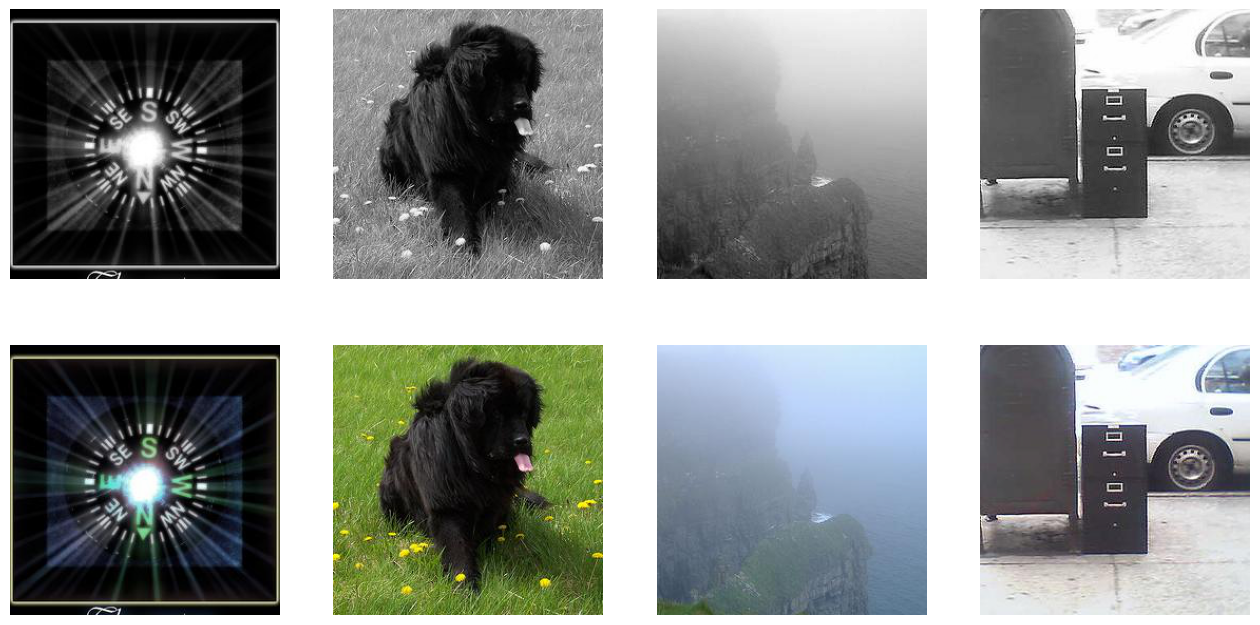

In [8]:
def display_batch(loader):
    """
    Display a few images from the specified data loader.
    (For discovering the dataset)
    """
    
    input, target = next(iter(loader))
    input, target = denormalize_lab(input, target)
    Lab = torch.cat([input, target], dim=1)
    RGB = color.lab_to_rgb(Lab)
    
    input = input.permute(0, 2, 3, 1).cpu().numpy()
    target = RGB.permute(0, 2, 3, 1).cpu().numpy()
    
    plt.figure(figsize=(16, 8))
    for i in range(2):
        for j in range(4):
            plt.subplot(2, 4, i * 4 + j + 1)
            if i == 0:
                plt.imshow(input[j], cmap="gray")
            else:
                plt.imshow(target[j])
            plt.axis('off')

    plt.show()

display_batch(train_loader)

### 5.6 Model architecture
Here are the custom modules that will be used to build the generator and discriminator models. The generator is a U-Net architecture with skip connections that will be used to colorize the images. The discriminator is a PatchGAN architecture that will be used to distinguish between real and fake images.

#### 5.6.1  The generator
The generator consists of two parts: encoder and decoder. The encoder down-samples the input image and extracts features from it, while the decoder up-samples the features and reconstructs the output image. The encoder consists of 8 blocks that down-sample the image by a factor of 2 each time, while the decoder consists of 8 blocks that up-sample the image by a factor of 2 each time. Therefore, the output remains the same size. Reflect padding is used for the image to keep its context when applying convolutions.

General order of layers in a Down-sampling block is:
- 2D Convolutional layer (kernel size 4x4, stride 2, padding 1 (same), padding mode 'reflect', no bias)
- 2D Instance Normalization layer with an affine parameters (that's why bias is set to False in Conv2d, it's redundant)
- LeakyReLU (negative slope 0.2) activation function

The only exceptions are the first and last layers of the encoder, where normalization is not applied (in such case bias is set to True in the Conv2d layer). Authors say that normalizing in the first layer result in significant loss of information and the last layer simply can't be normalized as it has only 1x1 spatial resolution. You can enable it if you're training on bigger images.

General order of layers in an Up-sampling block is:
- 2D Transposed Convolutional layer (kernel size 4x4, stride 2, padding 1 (same), no bias)
- 2D Instance Normalization layer with an affine parameters
- ReLU activation function

Exceptions are:
- First 3 layers of the decoder, where a dropout layer is applied with p=0.5 after the normalization layer.
- Last layer of the decoder, where Tanh is the activation function instead of ReLU and normalization is removed.

Following a UNet architecture, each down-sampled layer is then concatenated with a corresponding up-sampled layer of the same spatial shape. This is the skip connection that helps the model to retain spatial information and improve the quality of the output.

Generator takes BS x 1 x 256 x 256 tensor input and outputs BS x 2 x 256 x 256 tensor, so input is the grayscale image and output is the ab channels of the colorized image.

See code below to understand it better. It is easy to follow as the model is built using sequential blocks and well-commented.

In [9]:
# Dropout layer that works even in the evaluation mode
class DropoutAlways(nn.Dropout2d):
    def forward(self, x):
        return F.dropout2d(x, self.p, training=True)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, padding_mode='reflect', bias=False if normalize else True),
            nn.InstanceNorm2d(out_channels, affine=True) if normalize else nn.Identity(), # Note that nn.Identity() is just a placeholder layer that returns its input.
            nn.LeakyReLU(0.2),
        )       
        
    def forward(self, x):
        return self.block(x)
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=False, activation='relu'):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False if normalize else True),
            nn.InstanceNorm2d(out_channels, affine=True) if normalize else nn.Identity(),
            DropoutAlways(p=0.5) if dropout else nn.Identity(),
            nn.ReLU() if activation == 'relu' else nn.Tanh(),
        )
        
    def forward(self, x):
        return self.block(x)

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder1 = DownBlock(1, 64, normalize=False) # 256x256 -> 128x128
        self.encoder2 = DownBlock(64, 128) # 128x128 -> 64x64
        self.encoder3 = DownBlock(128, 256) # 64x64 -> 32x32
        self.encoder4 = DownBlock(256, 512) # 32x32 -> 16x16
        self.encoder5 = DownBlock(512, 512) # 16x16 -> 8x8
        self.encoder6 = DownBlock(512, 512) # 8x8 -> 4x4
        self.encoder7 = DownBlock(512, 512) # 4x4 -> 2x2
        self.encoder8 = DownBlock(512, 512, normalize=False) # 2x2 -> 1x1

        # Decoder
        self.decoder1 = UpBlock(512, 512, dropout=True) # 1x1 -> 2x2
        self.decoder2 = UpBlock(512*2, 512, dropout=True) # 2x2 -> 4x4
        self.decoder3 = UpBlock(512*2, 512, dropout=True) # 4x4 -> 8x8
        self.decoder4 = UpBlock(512*2, 512) # 8x8 -> 16x16
        self.decoder5 = UpBlock(512*2, 256) # 16x16 -> 32x32
        self.decoder6 = UpBlock(256*2, 128) # 32x32 -> 64x64
        self.decoder7 = UpBlock(128*2, 64) # 64x64 -> 128x128
        self.decoder8 = UpBlock(64*2, 2, normalize=False, activation='tanh') # 128x128 -> 256x256

    def forward(self, x):
        # Encoder
        ch256_down = x
        ch128_down = self.encoder1(ch256_down)
        ch64_down = self.encoder2(ch128_down)
        ch32_down = self.encoder3(ch64_down)
        ch16_down = self.encoder4(ch32_down)
        ch8_down = self.encoder5(ch16_down)
        ch4_down = self.encoder6(ch8_down)
        ch2_down = self.encoder7(ch4_down)
        ch1 = self.encoder8(ch2_down)

        # Decoder
        ch2_up = self.decoder1(ch1)
        ch2 = torch.cat([ch2_up, ch2_down], dim=1)
        ch4_up = self.decoder2(ch2)
        ch4 = torch.cat([ch4_up, ch4_down], dim=1)
        ch8_up = self.decoder3(ch4)
        ch8 = torch.cat([ch8_up, ch8_down], dim=1)
        ch16_up = self.decoder4(ch8)
        ch16 = torch.cat([ch16_up, ch16_down], dim=1)
        ch32_up = self.decoder5(ch16)
        ch32 = torch.cat([ch32_up, ch32_down], dim=1)
        ch64_up = self.decoder6(ch32)
        ch64 = torch.cat([ch64_up, ch64_down], dim=1)
        ch128_up = self.decoder7(ch64)
        ch128 = torch.cat([ch128_up, ch128_down], dim=1)
        ch256_up = self.decoder8(ch128)
        
        return ch256_up

In [11]:
# Test cell for output shape verification
model = Generator().to(DEVICE)
dummy_input = torch.randn(1, 1, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
output = model(dummy_input)
print(f'Output shape: {output.shape}') # Should be 1x2x256x256

Output shape: torch.Size([1, 2, 256, 256])


#### 5.6.2  The discriminator
The discriminator consists of 4 down-sampling (mostly) layers and has a structure called a Patch GAN. It is a type of discriminator that classifies each patch of the input image as real or fake.

Single block structure:
- 2D Convolutional layer (kernel size 4x4, stride 2, padding 1, padding mode 'reflect', no bias)
- 2D Batch Normalization layer
- LeakyReLU (negative slope 0.2) activation function

Exceptions:
- First layer doesn't have normalization (therefore, set bias=True in Conv2d)
- Two last layers have stride of 1
- Last layer doesn't have normalization nor activation function

The discriminator takes BS x 3 x 256 x 256 tensor input and outputs BS x 1 x 30 x 30 tensor, so input is the colorized image and output is the probability of each patch being real or fake.

In [12]:
class BlockD(nn.Module):
    def __init__(self, in_channels, out_channels, stride, normalize=True):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias = False if normalize else True, padding_mode='reflect'),
            nn.BatchNorm2d(out_channels) if normalize else nn.Identity(),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.model(x)

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            BlockD(3, 64, 2, normalize=False), # 256x256 -> 128x128
            BlockD(64, 128, 2), # 128x128 -> 64x64
            BlockD(128, 256, 2), # 64x64 -> 32x32
            BlockD(256, 512, 1), # 32x32 -> 31x31
            nn.Conv2d(512, 1, 4, 1, 1), # 31x31 -> 30x30
        )

    def forward(self, x):
        return self.model(x)

In [14]:
# Test cell for output shape verification
discriminator = Discriminator().to(DEVICE)
dummy_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
output = discriminator(dummy_input)
print(f'Output shape: {output.shape}') # Should be 1x1x30x30

Output shape: torch.Size([1, 1, 30, 30])


In [15]:
# Count trainable parameters of both models
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The generator has {count_parameters(Generator()):,} trainable parameters')
print(f'The discriminator has {count_parameters(Discriminator()):,} trainable parameters')

The generator has 54,410,434 trainable parameters
The discriminator has 2,765,633 trainable parameters


### 5.7 Weights initialization
Weights in are initialized in a way proposed in the paper, which is a normal distribution of mean 0 and standard deviation 0.02. Note that bias is set to 0 in the Conv2d layers and for the normalization layers, the weights are set to 1 and the bias to 0.

In [16]:
def init_weights(m, mean=0.0, std=0.02):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, mean=mean, std=std)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    
    elif isinstance(m, (nn.BatchNorm2d, nn.InstanceNorm2d)):
        nn.init.normal_(m.weight, mean=1.0, std=std)
        nn.init.constant_(m.bias, 0)

def init_model(model):
    model.to(DEVICE)
    model.apply(init_weights)
    return model

### 5.8 Model initialization
Here the generator and discriminator are being initialized with the desired weights. Each model needs its own optimizer (Adam) with the learning rate established in the 'Constants' chapter and beta values from the paper: 0.5, 0.999. I used a GradScaler to enable mixed precision training, which will reduce the training time without noticeably harming the accuracy.

If the LOAD_MODEL constant is true, already existing model will be loaded. This is useful when you want to continue training or test the model without training it from scratch.

The losses are defined here too. As mentioned before: L1 for generator regression and MSE (LSGAN loss) as the adversarial loss for both models.

In [17]:
generator = init_model(Generator())
discriminator = init_model(Discriminator())
opt_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
g_scaler = torch.amp.GradScaler()
d_scaler = torch.amp.GradScaler()

if LOAD_MODEL:
    generator.load_state_dict(torch.load(f'{MODEL_SOURCE}/generator.pth', weights_only=True))
    discriminator.load_state_dict(torch.load(f'{MODEL_SOURCE}/discriminator.pth', weights_only=True))
    opt_G.load_state_dict(torch.load(f'{MODEL_SOURCE}/opt_G.pth', weights_only=True))
    opt_D.load_state_dict(torch.load(f'{MODEL_SOURCE}/opt_D.pth', weights_only=True))
    print(f'{MODEL_SOURCE} model loaded.')

L1criterion = nn.L1Loss()
GANcriterion = nn.MSELoss()

models/new6 model loaded.


##  6 Training
For the model to achieve reasonable results you will need about 2 epochs (each about 2 hours of training on RTX 2070 SUPER). About 8-10 epochs more should provide very satisfying outputs. In GANs it is common not to measure the loss on the validation data but rather look at the generated images and decide if the model is good enough. In this case, we will just inspect the outputs and see how the model is performing on the validation set every few hundred iterations (since epochs would be too rarely). I've also implemented label smoothing for the discriminator loss, which will make its predictions less confident and prevent from overpowering the generator.

For the training loop overview look at the code below. It is commented very thoroughly:

In [18]:
def train_model(generator, discriminator, opt_G, opt_D, train_loader, val_loader, GANcriterion, L1criterion, num_epochs=10):
    
    # Providing a unique directory name for saving the outputs and saved model's weights
    save_directory = f"v{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    
    # A sample batch for visualization
    sample_val = next(iter(val_loader))
    sample_train = next(iter(train_loader))
    
    for epoch in range(num_epochs):
        print(10 * '*')
        print(f'Epoch {epoch + 1}/{num_epochs}') # Print the current epoch
        print(10 * '*')
        
        loss_meter_dict = create_loss_meters() # Dictionary responsible for storing the losses
        
        iteration = 1
        for L, ab in tqdm(train_loader): # tqdm is used for displaying the progress bar
            # Move the data to the device
            L = L.to(DEVICE)
            ab = ab.to(DEVICE)
            
            # Train the Discriminator
            discriminator.train() # Set the discriminator to training mode
            opt_D.zero_grad() # Zero the gradients of the discriminator's optimizer
            
            with torch.amp.autocast(DEVICE): # Automatic mixed precision for faster training
                real_image = torch.cat([L, ab], dim=1) # Concatenate the L and ab channels to get the real image
                
                D_real = discriminator(real_image) # Get the discriminator's prediction for the real image
                D_real_loss = GANcriterion(D_real, torch.ones_like(D_real) - 0.1 * torch.rand_like(D_real)) # Calculate the loss for the real image (add noise to the labels to prevent the discriminator from getting too strong)
                
                fake_ab = generator(L) # Generate the fake ab channels using the generator
                fake_image = torch.cat([L, fake_ab], dim=1) # Concatenate the L and fake ab channels to get the fake image
                
                D_fake = discriminator(fake_image.detach()) # Get the discriminator's prediction for the fake image (detach the fake image to prevent backpropagation to the generator)
                D_fake_loss = GANcriterion(D_fake, torch.zeros_like(D_fake) + 0.1 * torch.rand_like(D_fake)) # Calculate the loss for the fake image
                
                D_loss = (D_real_loss + D_fake_loss) / 2. # Calculate the total loss for the discriminator
                
            d_scaler.scale(D_loss).backward() # Scale the loss and backpropagate (mixed-precision requirement)
            d_scaler.step(opt_D) # Update the discriminator's weights
            d_scaler.update() # Update the scaler (mixed-precision requirement)
    
            # Train the Generator
            generator.train() # Set the generator to training mode
            opt_G.zero_grad() # Zero the gradients of the generator's optimizer
            
            with torch.amp.autocast(DEVICE): # Automatic mixed precision for faster training
                D_fake = discriminator(fake_image) # Get the discriminator's prediction for the fake image
                G_fake_loss = GANcriterion(D_fake, torch.ones_like(D_fake)) # Calculate the loss for the generator
                L1_loss = L1criterion(fake_ab, ab) * 25. # Calculate the L1 loss for the generator (multiplied by lambda=25 for maintaining balance between the losses)
                
                G_loss = G_fake_loss + L1_loss # Calculate the total loss for the generator
            
            g_scaler.scale(G_loss).backward() # Scale the loss and backpropagate (mixed-precision requirement)
            g_scaler.step(opt_G) # Update the generator's weights
            g_scaler.update() # Update the scaler (mixed-precision requirement)

            # Every 100 iterations, update the losses and visualize the results
            if iteration % 100 == 0:
                loss_meter_dict['loss_D_fake'].update(D_fake_loss.item())
                loss_meter_dict['loss_D_real'].update(D_real_loss.item())
                loss_meter_dict['loss_D'].update(D_loss.item())
                loss_meter_dict['loss_G_GAN'].update(G_fake_loss.item())
                loss_meter_dict['loss_G_L1'].update(L1_loss.item())
                loss_meter_dict['loss_G'].update(G_loss.item())
                
            if iteration % 100 == 0:
                print(10 * '=')
                print_losses(loss_meter_dict) # Print the losses
                
                visualize(generator, sample_val, epoch*100000 + iteration//100, 'val', save_directory, num=4) # Visualize the results on the validation set
                visualize(generator, sample_train, epoch*100000 + iteration//100, 'train', save_directory, num=4) # Visualize the results on the training set
        
                if SAVE_MODEL:
                    save_model(generator, discriminator, opt_G, opt_D, save_directory) # Save the model's weights
                    
            iteration += 1 # Increment the iteration number

In [ ]:
train_model(generator, discriminator, opt_G, opt_D, train_loader, val_loader, GANcriterion, L1criterion, num_epochs=1)

In [19]:
# Save the model explicitly after training
save_model(generator, discriminator, opt_G, opt_D, 'trained_model')

##  7 Model Inference
Below is the code for model inference. Here we can examine the results of the training process and see how does the model colorize new unseen grayscale images. Remember that it is neccessary to preprocess the input image exactly the same way as the training data before passing it to the model (convert to Lab and normalize). You also need to denormalize and convert the output back to the RGB format to visualize it properly.

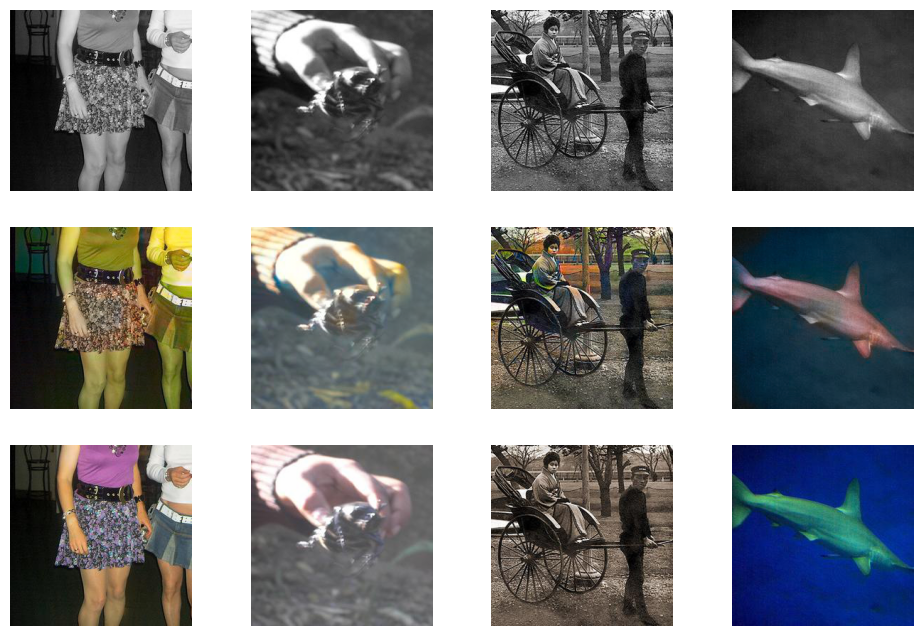

In [95]:
# Load the trained model
model = Generator()
model.load_state_dict(torch.load('models/trained_model/generator.pth', weights_only=True))
model = model.to(DEVICE)
model.eval() # Set the model to evaluation mode

test_loader = DataLoader(val_dataset, batch_size=16, shuffle=True) # Shuffle the validation data to inspect on different inputs

# Load example validation batch
L, ab = next(iter(test_loader))
L, ab = L.to(DEVICE), ab.to(DEVICE)

# Generate the output
fake_ab = model(L)
fake_ab = fake_ab.detach()

# Preprocess the result
L, ab = denormalize_lab(L, ab)
_, fake_ab = denormalize_lab(0, fake_ab)
real_imgs = color.lab_to_rgb(torch.cat([L, ab], dim=1)).permute(0, 2, 3, 1).cpu()
fake_imgs = color.lab_to_rgb(torch.cat([L, fake_ab], dim=1)).permute(0, 2, 3, 1).cpu()
L = L.permute(0, 2, 3, 1).cpu()

# Plot the results
fig = plt.figure(figsize=(15, 8))
for i in range(4):
    ax = plt.subplot(3, 5, i + 1)
    ax.imshow(L[i], cmap='gray')
    ax.axis("off")
    ax = plt.subplot(3, 5, i + 1 + 5)
    ax.imshow(fake_imgs[i])
    ax.axis("off")
    ax = plt.subplot(3, 5, i + 1 + 10)
    ax.imshow(real_imgs[i])
    ax.axis("off")
    
plt.show()

## 8 Conclusion
In this project I've implemented a Pix2Pix architecture image colorization model using PyTorch. I've trained the model on a subset of the ImageNet dataset and extended it with CelebA and Sports datasets. The model achieved impressive results after training for 15 epochs, which took about 30 hours on RTX 2070 SUPER GPU. The model is able to colorize grayscale images with high accuracy and generalizes well to new unseen images (even of size bigger than 256x256). I hope you enjoyed this notebook and found it useful. If you have any questions or suggestions, feel free to leave feedback. Thank you for reading and may the colors be with you!

## 9 Deployment
I've also deployed the model on Hugging Face Spaces platform using Gradio. You can colorize your own images using the model by following this link: <a href='https://huggingface.co/spaces/matikosowy/Photo_Colorizer'>Photo Colorizer</a>. On the site you can either upload the image directly thorugh the app or use the API. Model's performance might be slightly reduced, as its running on a CPU.

Implementation details:
1. Bigger image sizes handling (results won't be as good as for 256x256 images).
- The input image is padded to the nearest power of 2 size in both dimensions, as the model's architecture requires it.
- The padding is done with the 'reflect' mode, which will preserve the image's context (black or white padding would introduce artifacts).
- The output image is cropped to the original size after colorization.

![title](resources/gradio.png)

API access:

![title](resources/api-python.png)
![title](resources/api-js.png)

## 10 References
- Phillip Isola, Jun-Yan Zhu, Tinghui Zhou, Alexei A. Efros, "<a href='https://arxiv.org/abs/1611.07004'>Image-to-Image Translation with Conditional Adversarial Networks</a>", November 21, 2016, 
- Xudong Mao, Qing Li, Haoran Xie, Raymond Y.K. Lau, Zhen Wang, Stephen Paul Smolley, "<a href='https://arxiv.org/abs/1611.04076'>Least Squares Generative Adversarial Networks</a>", November 13, 2016
- Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio, "<a href='https://arxiv.org/abs/1406.2661'>Generative Adversarial Networks</a>", June 10, 2014
- David Foster, "Generative Deep Learning 2nd edition" book, 2023
- Aurelien Geron, "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow 3rd edition" book, 2023
- https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
- https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/Pix2Pix
- https://colab.research.google.com/github/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/Image%20Colorization%20with%20U-Net%20and%20GAN%20Tutorial.ipynb
- https://www.kaggle.com/code/theblackmamba31/pix2pix-gan-coloring-images